[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [6]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [7]:
# Define the logistic (sigmoid) function
# Maps any real number to the range (0, 1)
# σ(z) = 1 / (1 + exp(-z))
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    
    def __init__(self, M=64):
        """
        Initialize a 2-layer neural network (Multi-Layer Perceptron).
        
        Architecture: x -> [V] -> σ -> [W] -> σ -> ŷ
        
        Parameters:
        M: number of hidden units in the hidden layer (default: 64)
        
        Model equation:
        ŷ = σ(W^T σ(V^T x))
        where V ∈ R^(D×M), W ∈ R^M, x ∈ R^D
        """
        self.M = M
            
    def fit(self, x, y, optimizer):
        """
        Fit the MLP model using backpropagation and gradient descent.
        
        Parameters:
        x: input features, shape (N, D) where N=samples, D=features
        y: binary labels (0 or 1), shape (N,)
        optimizer: optimizer object with a run() method (e.g., GradientDescent)
        
        Returns:
        self: fitted model with learned parameters stored in self.params
        """
        N, D = x.shape
        
        def gradient(x, y, params):
            """
            Compute gradients for both layers using backpropagation.
            
            Parameters:
            x: input features, shape (N, D)
            y: true labels, shape (N,)
            params: list [v, w] where v is (D, M) and w is (M,)
            
            Returns:
            dparams: list [dv, dw] containing gradients for V and W
            
            Implementation note: This computes gradients for ALL parameters
            simultaneously using vectorized operations (not one at a time).
            """
            v, w = params  # v: (D, M), w: (M,)
            
            # ===== Forward pass =====
            # Compute hidden layer activations
            # x @ v: (N, D) @ (D, M) = (N, M)
            # Each of N samples produces M hidden unit pre-activations
            # logistic applies element-wise: z[i,j] = σ(sum_d x[i,d] * v[d,j])
            z = logistic(np.dot(x, v))  # Shape: (N, M)
            
            # Compute output predictions
            # z @ w: (N, M) @ (M,) = (N,)
            # For each sample: yh[i] = σ(sum_m z[i,m] * w[m])
            yh = logistic(np.dot(z, w))  # Shape: (N,)
            
            # ===== Backward pass (backpropagation) =====
            # Output layer gradient
            # dy is the error at the output: ŷ - y
            dy = yh - y  # Shape: (N,)
            
            # Gradient for output weights W
            # z.T @ dy: (M, N) @ (N,) = (M,)
            # dw[j] = (1/N) * sum_i z[i,j] * dy[i]
            # This tells us how to adjust each output weight
            dw = np.dot(z.T, dy) / N  # Shape: (M,)
            
            # Gradient flowing back to hidden layer
            # np.outer(dy, w): (N,) ⊗ (M,) = (N, M)
            # outer product: dz[i,j] = dy[i] * w[j]
            # This distributes the output error to each hidden unit
            # proportional to the weight connecting that unit to the output
            dz = np.outer(dy, w)  # Shape: (N, M)
            
            # Gradient for hidden layer weights V
            # Chain rule: need to multiply by derivative of sigmoid
            # σ'(a) = σ(a) * (1 - σ(a)), so we use z * (1 - z)
            # dz * z * (1-z) applies the sigmoid derivative element-wise
            # x.T @ (dz * z * (1-z)): (D, N) @ (N, M) = (D, M)
            # dv[d,j] = (1/N) * sum_i x[i,d] * dz[i,j] * z[i,j] * (1 - z[i,j])
            dv = np.dot(x.T, dz * z * (1 - z)) / N  # Shape: (D, M)
            
            dparams = [dv, dw]
            return dparams
        
        # Initialize weights with small random values (breaking symmetry)
        # Random initialization prevents all hidden units from learning the same thing
        # Scale by 0.01 to keep initial values small
        w = np.random.randn(self.M) * .01  # Shape: (M,)
        v = np.random.randn(D, self.M) * .01  # Shape: (D, M)
        
        # Store parameters as a list for the optimizer
        params0 = [v, w]
        
        # Run optimization (gradient descent updates params iteratively)
        self.params = optimizer.run(gradient, x, y, params0)
        
        return self
    
    def predict(self, x):
        """
        Predict class probabilities for input x using learned parameters.
        
        Parameters:
        x: input features, shape (N, D)
        
        Returns:
        yh: predicted probabilities P(y=1|x), shape (N,)
        """
        v, w = self.params  # Extract learned weights
        
        # Forward pass (same as in gradient computation)
        # Hidden layer: x @ v then apply sigmoid
        z = logistic(np.dot(x, v))  # Shape: (N, M)
        
        # Output layer: z @ w then apply sigmoid
        yh = logistic(np.dot(z, w))  # Shape: (N,)
        
        return yh

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [8]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        """
        Initialize Gradient Descent optimizer.
        
        This optimizer works with models that have multiple parameter matrices/vectors
        stored as a list (e.g., [V, W] for a 2-layer network).
        
        Parameters:
        learning_rate: step size for parameter updates (also called alpha)
        max_iters: maximum number of gradient descent iterations
        epsilon: convergence threshold - stop when all gradient norms < epsilon
        """
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        """
        Run gradient descent optimization to minimize the loss.
        
        Parameters:
        gradient_fn: function that computes gradients given (x, y, params)
        x: input features, shape (N, D)
        y: target labels, shape (N,)
        params: list of parameter arrays to optimize (e.g., [V, W])
        
        Returns:
        params: optimized parameters after gradient descent
        
        The optimization loop:
        1. Compute gradients for all parameters
        2. Update each parameter: param_new = param_old - learning_rate * gradient
        3. Repeat until convergence or max iterations reached
        """
        # Initialize gradient norms to infinity (ensures loop starts)
        # We track the norm (magnitude) of each gradient to check convergence
        norms = np.array([np.inf])
        
        # Iteration counter
        t = 1
        
        # Continue until ALL gradient norms are small enough OR max iterations reached
        # np.any(norms > epsilon) checks if ANY gradient is still too large
        while np.any(norms > self.epsilon) and t < self.max_iters:
            # Compute gradients for all parameters
            # gradient_fn returns a list of gradients [dv, dw] matching params structure
            grad = gradient_fn(x, y, params)
            
            # Update each parameter in the list
            # This loop handles both V (matrix) and W (vector) automatically
            for p in range(len(params)):
                # Standard gradient descent update rule
                # Move in opposite direction of gradient (downhill)
                params[p] -= self.learning_rate * grad[p]
            
            t += 1
            
            # Compute the norm (L2 norm) of each gradient
            # List comprehension: [norm(dv), norm(dw)]
            # Used to check if we've converged (gradients near zero)
            norms = np.array([np.linalg.norm(g) for g in grad])
        
        return params

## Iris dataset
Let's apply this to do binary classification with Iris flowers dataset. 
Below we run gradient descent for a large number of iterations and plot the decision boundary.

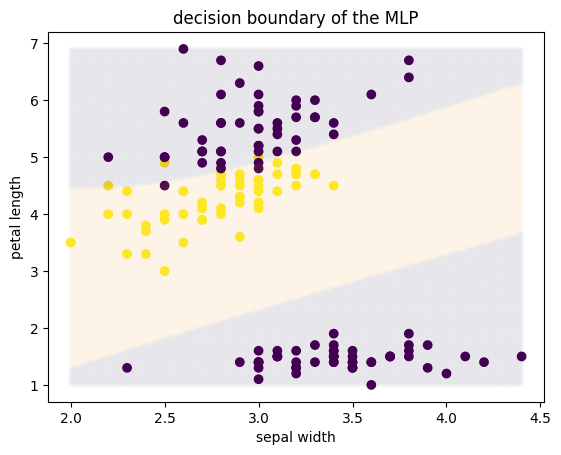

In [9]:
from sklearn import datasets

# Load the famous Iris dataset (150 samples, 4 features, 3 classes)
dataset = datasets.load_iris()

# Extract features and labels
# dataset['data'] has shape (150, 4): [sepal length, sepal width, petal length, petal width]
# We select columns 1 and 2: sepal width and petal length
# x[:, [1,2]] uses advanced indexing to select specific columns
# Result: x has shape (150, 2)
x, y = dataset['data'][:, [1, 2]], dataset['target']

# Convert to binary classification problem
# y == 1 creates a boolean array: True where y is class 1, False otherwise
# This converts the 3-class problem (0, 1, 2) to binary (True/False)
# True represents class 1 (Versicolor), False represents other classes
y = y == 1

# Initialize MLP with 32 hidden units
# This creates a 2-layer network: (2 features) -> (32 hidden) -> (1 output)
model = MLP(M=32)

# Set up optimizer with specific hyperparameters
# learning_rate=0.1: relatively large step size (network can learn quickly)
# max_iters=20000: run for many iterations to ensure convergence
optimizer = GradientDescent(learning_rate=.1, max_iters=20000)

# Train the model and get predictions on training data
yh = model.fit(x, y, optimizer).predict(x)

# ===== Create visualization grid =====
# To visualize the decision boundary, we need to evaluate the model
# at every point in a 2D grid covering the feature space

# Create 200 evenly spaced points along each feature dimension
# This covers the range of the training data
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)  # sepal width range
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)  # petal length range

# Create 2D mesh grid
# x0 and x1 are both (200, 200) arrays
# x0[i,j] contains the sepal width value at grid point (i,j)
# x1[i,j] contains the petal length value at grid point (i,j)
x0, x1 = np.meshgrid(x0v, x1v)

# Flatten and combine to create array of all grid points
# ravel() flattens (200, 200) -> (40000,)
# vstack stacks the two 1D arrays vertically: (2, 40000)
# .T transposes to get (40000, 2)
# Each row is a point [sepal width, petal length] in the 2D feature space
x_all = np.vstack((x0.ravel(), x1.ravel())).T

# Predict for all grid points
# yh_all has shape (40000,) with probabilities P(y=1|x)
# > .5 converts to binary predictions: True if P(y=1|x) > 0.5, else False
yh_all = model.predict(x_all) > .5

# ===== Plot the results =====
# Training data points (circles, colored by true labels)
# c=y colors the points: False (class 0) vs True (class 1)
# alpha=1 makes them fully opaque so they stand out
plt.scatter(x[:, 0], x[:, 1], c=y, marker='o', alpha=1)

# Background grid points show the decision boundary
# c=yh_all colors regions by predicted class
# alpha=.01 makes them very transparent - creates a smooth background
# The boundary is where predictions change from False to True
plt.scatter(x_all[:, 0], x_all[:, 1], c=yh_all, marker='.', alpha=.01)

# Labels and title
plt.xlabel('sepal width')
plt.ylabel('petal length')
plt.title('decision boundary of the MLP')
plt.show()

# PyTorch Implementation

Now let's implement the exact same MLP architecture using PyTorch. The key advantage of PyTorch is that it handles backpropagation automatically through automatic differentiation, eliminating the need for manual gradient calculations. This results in much simpler, cleaner code while achieving the same results.

We'll use:
- The same architecture: 2 features → 32 hidden units → 1 output
- The same activation function: sigmoid (logistic)
- The same hyperparameters: learning rate = 0.1, max iterations = 20000
- The same Iris dataset subset

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP_PyTorch(nn.Module):
    """
    PyTorch implementation of a 2-layer neural network (MLP).
    
    Architecture: x -> [V] -> σ -> [W] -> σ -> ŷ
    
    This achieves the same result as the NumPy implementation above,
    but with automatic differentiation - no manual gradient calculation needed!
    """
    
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=1):
        """
        Initialize the MLP layers.
        
        Parameters:
        input_dim: number of input features (D)
        hidden_dim: number of hidden units (M)
        output_dim: number of output units (1 for binary classification)
        """
        super(MLP_PyTorch, self).__init__()
        
        # Define the two layers
        # nn.Linear(D, M) creates the first layer: x @ V (D inputs -> M hidden units)
        # nn.Linear(M, 1) creates the second layer: z @ W (M hidden -> 1 output)
        # PyTorch handles weight initialization automatically
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
        # Sigmoid activation function (same as logistic function in NumPy version)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters:
        x: input features, shape (N, D)
        
        Returns:
        out: predicted probabilities, shape (N, 1)
        
        This implements: ŷ = σ(W^T σ(V^T x))
        """
        # First layer: linear transformation then sigmoid activation
        # hidden: (N, D) @ (D, M) = (N, M)
        hidden = self.sigmoid(self.hidden(x))
        
        # Second layer: linear transformation then sigmoid activation
        # out: (N, M) @ (M, 1) = (N, 1)
        out = self.sigmoid(self.output(hidden))
        
        return out

In [ ]:
# Use the same dataset (x, y) that was loaded above for the NumPy implementation
# Convert NumPy arrays to PyTorch tensors
# .float() converts to 32-bit floating point (required for neural networks)
x_torch = torch.from_numpy(x).float()  # Shape: (150, 2)
y_torch = torch.from_numpy(y.astype(np.float32)).float().reshape(-1, 1)  # Shape: (150, 1)

# Initialize the PyTorch model with 32 hidden units (same as NumPy version)
model_torch = MLP_PyTorch(input_dim=2, hidden_dim=32, output_dim=1)

# Define loss function: Binary Cross-Entropy Loss
# Equivalent to: -[y*log(ŷ) + (1-y)*log(1-ŷ)]
criterion = nn.BCELoss()

# Define optimizer: Stochastic Gradient Descent
# PyTorch handles the parameter updates automatically!
optimizer_torch = optim.SGD(model_torch.parameters(), lr=0.1)

# Training loop
max_iters = 20000  # Same as NumPy version
for iteration in range(max_iters):
    # Forward pass: compute predictions
    # model_torch(x_torch) automatically calls forward() method
    yh_torch = model_torch(x_torch)
    
    # Compute loss (how far predictions are from true labels)
    loss = criterion(yh_torch, y_torch)
    
    # Backward pass: compute gradients automatically!
    # This is where PyTorch shines - no manual gradient calculation needed
    optimizer_torch.zero_grad()  # Clear previous gradients
    loss.backward()  # Automatically compute all gradients via backpropagation
    optimizer_torch.step()  # Update all parameters using computed gradients
    
    # print progress every 2000 iterations
    if (iteration + 1) % 2000 == 0:
        print(f'Iteration {iteration + 1}/{max_iters}, Loss: {loss.item():.4f}')

print(f'Final Loss: {loss.item():.4f}')

Iteration 2000/20000, Loss: 0.3406
Iteration 4000/20000, Loss: 0.1711
Iteration 6000/20000, Loss: 0.1391
Iteration 8000/20000, Loss: 0.1244
Iteration 10000/20000, Loss: 0.1161
Iteration 12000/20000, Loss: 0.1110
Iteration 14000/20000, Loss: 0.1078
Iteration 16000/20000, Loss: 0.1056
Iteration 18000/20000, Loss: 0.1041
Iteration 20000/20000, Loss: 0.1030
Final Loss: 0.1030


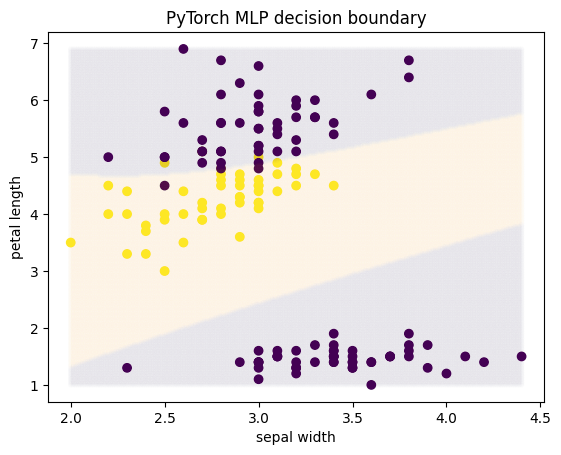

Training Accuracy: 96.00%


In [12]:
# Visualize the decision boundary (same approach as NumPy version)

# Set model to evaluation mode (disables dropout, batch norm if present)
model_torch.eval()

# Create the same 2D grid as before
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)  # sepal width range
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)  # petal length range
x0, x1 = np.meshgrid(x0v, x1v)

# Flatten and combine to get all grid points
x_all = np.vstack((x0.ravel(), x1.ravel())).T  # Shape: (40000, 2)

# Convert to PyTorch tensor for prediction
x_all_torch = torch.from_numpy(x_all).float()

# Make predictions for all grid points
# torch.no_grad() disables gradient computation (saves memory, speeds up inference)
with torch.no_grad():
    yh_all_torch = model_torch(x_all_torch)
    # Convert back to NumPy and apply threshold
    yh_all_torch = (yh_all_torch.numpy() > 0.5).reshape(-1)

# Get predictions for training data
with torch.no_grad():
    yh_train = (model_torch(x_torch).numpy() > 0.5).reshape(-1)

# Plot the results
# Training data points (colored by true labels)
plt.scatter(x[:, 0], x[:, 1], c=y, marker='o', alpha=1)

# Background grid shows decision boundary
plt.scatter(x_all[:, 0], x_all[:, 1], c=yh_all_torch, marker='.', alpha=.01)

plt.xlabel('sepal width')
plt.ylabel('petal length')
plt.title('PyTorch MLP decision boundary')
plt.show()

# Calculate and print accuracy
accuracy = np.mean(yh_train == y)
print(f'Training Accuracy: {accuracy * 100:.2f}%')

## Comparing the two implementations

The NumPy and PyTorch implementations produce nearly identical results, as you can see from the decision boundaries above. However, the PyTorch version achieves this with significantly less code and complexity.

### NumPy Implementation
- Manual backpropagation: Had to derive and implement gradients for both layers (about 30 lines of gradient code)
- Manual parameter updates: Implemented the gradient descent optimizer from scratch
- Error-prone: Easy to make mistakes in gradient calculations
- Not scalable: Adding more layers requires deriving new gradients each time

### PyTorch Implementation  
- Automatic differentiation: `.backward()` computes all gradients automatically
- Built-in optimizers: Just use `optim.SGD()` without implementing it ourselves
- Clean and concise: Model definition is straightforward, roughly 15 lines vs 80 lines for NumPy
- Easily extensible: Adding more layers just means adding more `nn.Linear` layers
- GPU acceleration: Can easily move to GPU with `.cuda()` for faster training on large datasets

### What stayed the same
Both implementations use the same architecture (2 features to 32 hidden units to 1 output), the same sigmoid activation function, the same hyperparameters (learning rate of 0.1, 20,000 iterations), and the same Iris dataset. They produce similar decision boundaries and accuracy.

The main takeaway is that PyTorch lets us focus on the model architecture and problem we're solving, rather than getting caught up in the implementation details of backpropagation. This is particularly valuable when working with deeper networks where manual gradient calculation becomes impractical.